In [1]:
import pandas as pd

uri = "https://gist.githubusercontent.com/guilhermesilveira/e99a526b2e7ccc6c3b70f53db43a87d2/raw/1605fc74aa778066bf2e6695e24d53cf65f2f447/machine-learning-carros-simulacao.csv"
dados = pd.read_csv(uri).drop(columns=["Unnamed: 0"], axis=1)
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


In [2]:
# situação horrível de "azar" onde as classes estão ordenadas por padrão

dados_azar = dados.sort_values("vendido", ascending=True)
x_azar = dados_azar[["preco", "idade_do_modelo", "km_por_ano"]]
y_azar = dados_azar["vendido"]
dados_azar.head()

,preco,vendido,idade_do_modelo,km_por_ano
4999,74023.29,0,12,24812.80412
5322,84843.49,0,13,23095.63834
5319,83100.27,0,19,36240.72746
5316,87932.13,0,16,32249.56426
5315,77937.01,0,15,28414.50704


In [3]:
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
import numpy as np

SEED = 301
np.random.seed(SEED)

modelo = DummyClassifier()
results = cross_validate(modelo, x_azar, y_azar, cv=10, return_train_score=False)
media = results["test_score"].mean()
desvio_padrao = results["test_score"].std()
print("Accuracy com dummy stratified, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao) * 100, (media + 2 * desvio_padrao) * 100))

Accuracy com dummy stratified, 10 = [49.79, 53.45]


/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


In [4]:
from sklearn.tree import DecisionTreeClassifier

modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv=10, return_train_score=False)
media = results["test_score"].mean()
desvio_padrao = results["test_score"].std()
print("Accuracy com cross validation, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao) * 100, (media + 2 * desvio_padrao) * 100))

Accuracy com cross validation, 10 = [73.83, 77.73]


In [5]:
# gerando dados aleatórios de modelo de carro para simulação de agrupamento ao usar nosso estimador

dados["modelo"] = dados.idade_do_modelo + np.random.randint(-2, 3, size=10000)
dados.modelo = dados.modelo + abs(dados.modelo.min()) + 1
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano,modelo
0,30941.02,1,18,35085.22134,20
1,40557.96,1,20,12622.05362,23
2,89627.50,0,12,11440.79806,16
3,95276.14,0,3,43167.32682,6
4,117384.68,1,4,12770.11290,8


In [6]:
def imprime_resultados(results):
  media = results["test_score"].mean() * 100
  desvio = results["test_score"].std() * 100
  print("Accuracy médio %.2f" % media)
  print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

In [7]:
# GroupKFold em um pipeline com StandardScaler e SVC

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold

scaler = StandardScaler()
modelo = SVC()

pipeline = Pipeline([("transformacao", scaler), ("estimador", modelo)])

cv = GroupKFold(n_splits=10)
results = cross_validate(pipeline, x_azar, y_azar, cv=cv, groups=dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 76.53
Intervalo [73.70, 79.37]


In [8]:
# GroupKFold para analisar como o modelo se comporta com novos grupos

cv = GroupKFold(n_splits=10)
modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv=cv, groups=dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 75.78
Intervalo [73.38, 78.18]


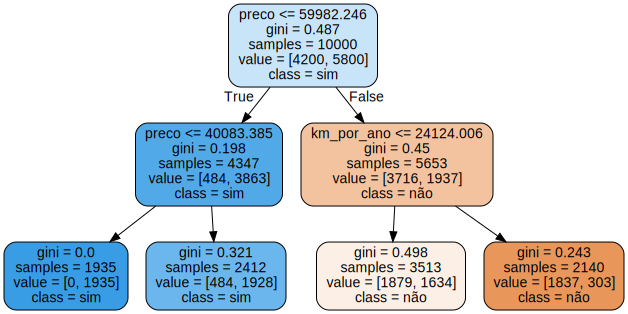

In [9]:
from sklearn.tree import export_graphviz
import graphviz

modelo.fit(x_azar, y_azar)
features = x_azar.columns
dot_data = export_graphviz(modelo, out_file=None, filled=True, rounded=True, class_names=["não", "sim"], feature_names=features)
graph = graphviz.Source(dot_data)
graph

In [10]:
cv = GroupKFold(n_splits=10)
modelo = DecisionTreeClassifier(max_depth=3)
results = cross_validate(modelo, x_azar, y_azar, cv=cv, groups=dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 78.67
Intervalo [75.32, 82.03]


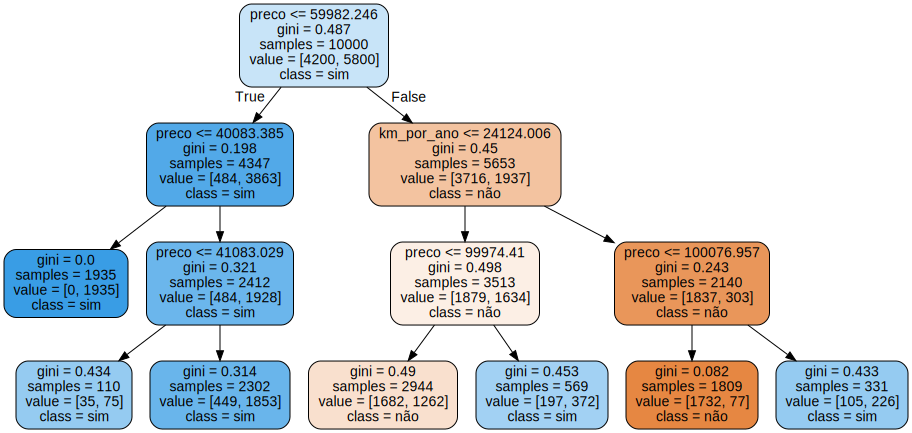

In [11]:
modelo.fit(x_azar, y_azar)
features = x_azar.columns
dot_data = export_graphviz(modelo, out_file=None, filled=True, rounded=True, class_names=["não", "sim"], feature_names=features)
graph = graphviz.Source(dot_data)
graph

In [12]:
cv = GroupKFold(n_splits=10)
modelo = DecisionTreeClassifier(max_depth=10)
results = cross_validate(modelo, x_azar, y_azar, cv=cv, groups=dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 76.90
Intervalo [74.02, 79.78]


# Testando parâmetros

In [13]:
def roda_arvore_de_decisao(max_depth):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits=10)
  modelo = DecisionTreeClassifier(max_depth=max_depth)
  results = cross_validate(modelo, x_azar, y_azar, cv=cv, groups=dados.modelo, return_train_score=True)

  train_score = results["train_score"].mean() * 100
  test_score = results["test_score"].mean() * 100
  # print("Árvore max_depth = %d, treino = %.2f, teste = %.2f" % (max_depth, train_score, test_score))

  tabela = [max_depth, train_score, test_score]
  return tabela

resultados = [roda_arvore_de_decisao(i) for i in range(1, 33)]
resultados = pd.DataFrame(resultados, columns=["max_depth", "train", "test"])
resultados.head()

,max_depth,train,test
0,1,75.791101,75.779083
1,2,75.791101,75.779083
2,3,78.755605,78.673716
3,4,78.793388,78.604045
4,5,78.935592,78.596576


# OVERFIT: ficou "perfeito" para o treino mas ruim para o teste

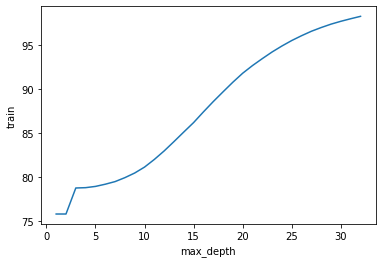

In [14]:
import seaborn as sns

sns.lineplot(x = "max_depth", y = "train", data = resultados)

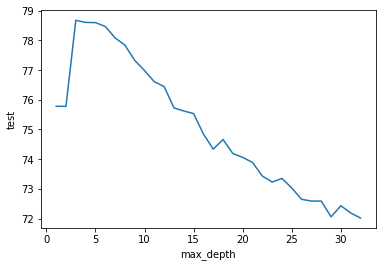

In [15]:
sns.lineplot(x = "max_depth", y = "test", data = resultados)

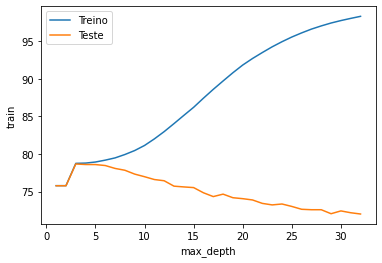

In [16]:
import matplotlib.pyplot as plt

sns.lineplot(x = "max_depth", y = "train", data = resultados)
sns.lineplot(x = "max_depth", y = "test", data = resultados)
plt.legend(["Treino", "Teste"])

In [17]:
resultados.sort_values("test", ascending=False).head()

,max_depth,train,test
2,3,78.755605,78.673716
3,4,78.793388,78.604045
4,5,78.935592,78.596576
5,6,79.185673,78.467568
6,7,79.484727,78.083640


# Explorando hiper parâmetros em 2 dimensões

In [18]:
def roda_arvore_de_decisao(max_depth, min_samples_leaf):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits=10)
  modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
  results = cross_validate(modelo, x_azar, y_azar, cv=cv, groups=dados.modelo, return_train_score=True)

  train_score = results["train_score"].mean() * 100
  test_score = results["test_score"].mean() * 100
  print("Árvore max_depth = %d, min_samples_leaf = %d, treino = %.2f, teste = %.2f" % (max_depth, min_samples_leaf, train_score, test_score))

  tabela = [max_depth, min_samples_leaf, train_score, test_score]
  return tabela

def busca():
  resultados = []
  for max_depth in range(1,33):
    for min_samples_leaf in [32, 64, 128, 256]:
      tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf)
      resultados.append(tabela)
  resultados = pd.DataFrame(resultados, columns=["max_depth", "min_samples_leaf", "train", "test"])
  return resultados

resultados = busca()
resultados.head()

Árvore max_depth = 1, min_samples_leaf = 32, treino = 75.79, teste = 75.78
Árvore max_depth = 1, min_samples_leaf = 64, treino = 75.79, teste = 75.78
Árvore max_depth = 1, min_samples_leaf = 128, treino = 75.79, teste = 75.78
Árvore max_depth = 1, min_samples_leaf = 256, treino = 75.79, teste = 75.78
Árvore max_depth = 2, min_samples_leaf = 32, treino = 75.79, teste = 75.78
Árvore max_depth = 2, min_samples_leaf = 64, treino = 75.79, teste = 75.78
Árvore max_depth = 2, min_samples_leaf = 128, treino = 75.79, teste = 75.78
Árvore max_depth = 2, min_samples_leaf = 256, treino = 75.79, teste = 75.78
Árvore max_depth = 3, min_samples_leaf = 32, treino = 78.75, teste = 78.67
Árvore max_depth = 3, min_samples_leaf = 64, treino = 78.75, teste = 78.67
Árvore max_depth = 3, min_samples_leaf = 128, treino = 78.75, teste = 78.67
Árvore max_depth = 3, min_samples_leaf = 256, treino = 78.75, teste = 78.67
Árvore max_depth = 4, min_samples_leaf = 32, treino = 78.75, teste = 78.67
Árvore max_depth = 

,max_depth,min_samples_leaf,train,test
0,1,32,75.791101,75.779083
1,1,64,75.791101,75.779083
2,1,128,75.791101,75.779083
3,1,256,75.791101,75.779083
4,2,32,75.791101,75.779083


In [19]:
resultados.sort_values("test", ascending=False).head()

,max_depth,min_samples_leaf,train,test
13,4,64,78.753381,78.673716
11,3,256,78.753381,78.673716
15,4,256,78.753381,78.673716
14,4,128,78.753381,78.673716
12,4,32,78.753381,78.673716


In [20]:
corr = resultados.corr()
corr

,max_depth,min_samples_leaf,train,test
max_depth,1.000000,0.000000,0.547410,-0.015495
min_samples_leaf,0.000000,1.000000,-0.405657,0.450476
train,0.547410,-0.405657,1.000000,0.193711
test,-0.015495,0.450476,0.193711,1.000000


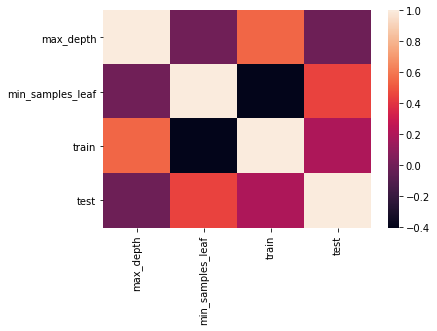

In [21]:
sns.heatmap(corr)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f85f35fcf28>,
      dtype=object)

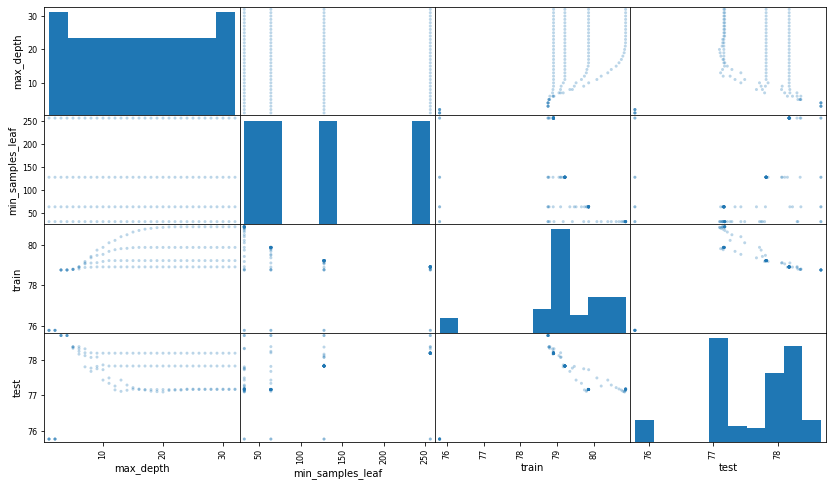

In [22]:
pd.plotting.scatter_matrix(resultados, figsize=(14, 8), alpha=0.3)

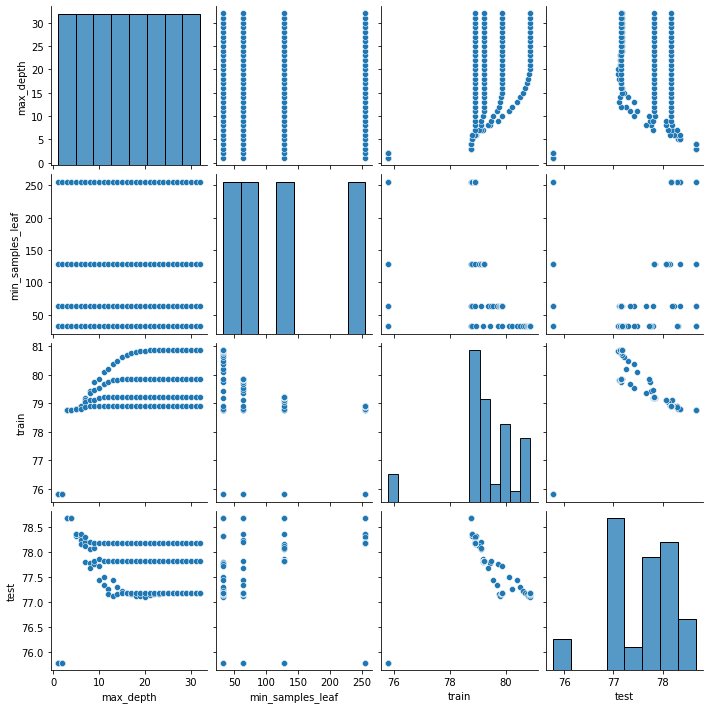

In [23]:
sns.pairplot(resultados)

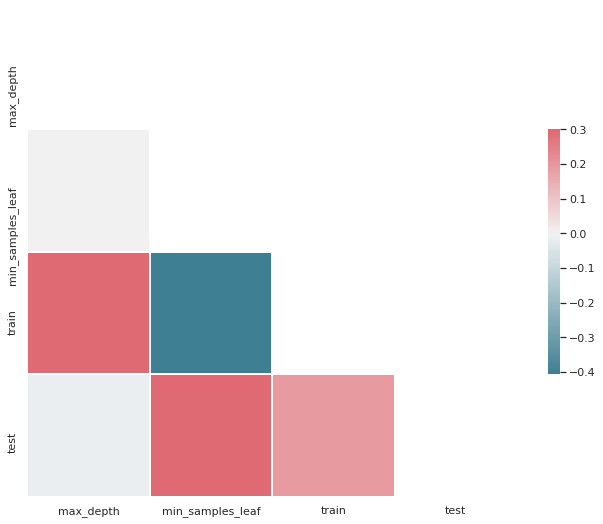

In [24]:
sns.set(style="white")

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [25]:
def busca():
  resultados = []
  for max_depth in range(1,33):
    for min_samples_leaf in [128, 192, 256, 512]:
      tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf)
      resultados.append(tabela)
  resultados = pd.DataFrame(resultados, columns=["max_depth", "min_samples_leaf", "train", "test"])
  return resultados

resultados = busca()
resultados.head()

Árvore max_depth = 1, min_samples_leaf = 128, treino = 75.79, teste = 75.78
Árvore max_depth = 1, min_samples_leaf = 192, treino = 75.79, teste = 75.78
Árvore max_depth = 1, min_samples_leaf = 256, treino = 75.79, teste = 75.78
Árvore max_depth = 1, min_samples_leaf = 512, treino = 75.79, teste = 75.78
Árvore max_depth = 2, min_samples_leaf = 128, treino = 75.79, teste = 75.78
Árvore max_depth = 2, min_samples_leaf = 192, treino = 75.79, teste = 75.78
Árvore max_depth = 2, min_samples_leaf = 256, treino = 75.79, teste = 75.78
Árvore max_depth = 2, min_samples_leaf = 512, treino = 75.79, teste = 75.78
Árvore max_depth = 3, min_samples_leaf = 128, treino = 78.75, teste = 78.67
Árvore max_depth = 3, min_samples_leaf = 192, treino = 78.75, teste = 78.67
Árvore max_depth = 3, min_samples_leaf = 256, treino = 78.75, teste = 78.67
Árvore max_depth = 3, min_samples_leaf = 512, treino = 77.53, teste = 77.51
Árvore max_depth = 4, min_samples_leaf = 128, treino = 78.75, teste = 78.67
Árvore max_d

,max_depth,min_samples_leaf,train,test
0,1,128,75.791101,75.779083
1,1,192,75.791101,75.779083
2,1,256,75.791101,75.779083
3,1,512,75.791101,75.779083
4,2,128,75.791101,75.779083


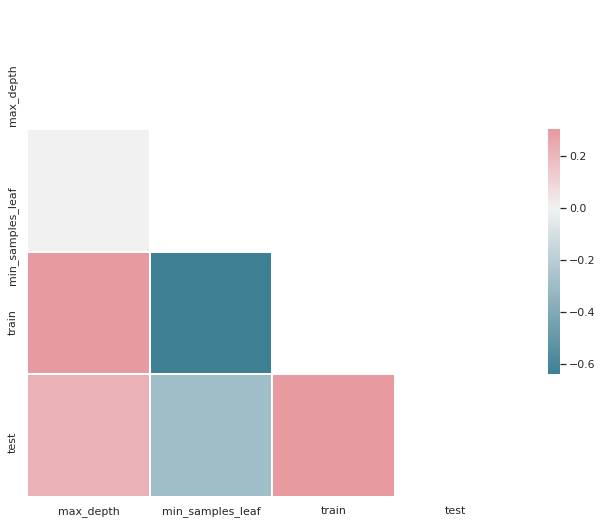

In [26]:
corr = resultados.corr()

sns.set(style="white")

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [27]:
resultados.sort_values("test", ascending=False).head()

,max_depth,min_samples_leaf,train,test
14,4,256,78.753381,78.673716
8,3,128,78.753381,78.673716
13,4,192,78.753381,78.673716
12,4,128,78.753381,78.673716
10,3,256,78.753381,78.673716


# Explorando 3 dimensões de hiper parâmetros

In [28]:
def roda_arvore_de_decisao(max_depth, min_samples_leaf, min_samples_split):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits=10)
  modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split)
  results = cross_validate(modelo, x_azar, y_azar, cv=cv, groups=dados.modelo, return_train_score=True)

  train_score = results["train_score"].mean() * 100
  test_score = results["test_score"].mean() * 100
  fit_time = results["fit_time"].mean()
  score_time = results["score_time"].mean()

  tabela = [max_depth, min_samples_leaf, min_samples_split, train_score, test_score, fit_time, score_time]
  return tabela

def busca():
  resultados = []
  for max_depth in range(1,33):
    for min_samples_leaf in [32, 64, 128, 256]:
      for min_samples_split in [32, 64, 128, 256]:
        tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf, min_samples_split)
        resultados.append(tabela)
  resultados = pd.DataFrame(resultados, columns=["max_depth", "min_samples_leaf", "min_samples_split", "train", "test", "fit_time", "score_time"])
  return resultados

resultados = busca()
resultados.head()

,max_depth,min_samples_leaf,min_samples_split,train,test,fit_time,score_time
0,1,32,32,75.791101,75.779083,0.005930,0.001325
1,1,32,64,75.791101,75.779083,0.005938,0.001311
2,1,32,128,75.791101,75.779083,0.005631,0.001293
3,1,32,256,75.791101,75.779083,0.005500,0.001259
4,1,64,32,75.791101,75.779083,0.005493,0.001244


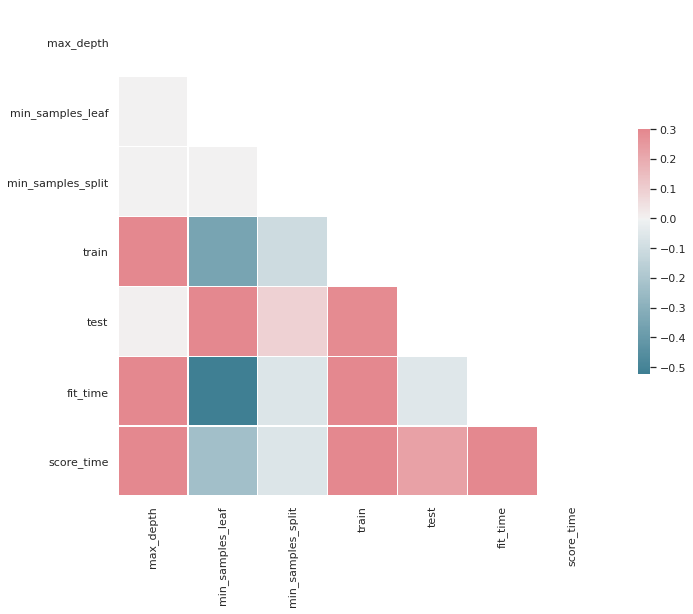

In [29]:
corr = resultados.corr()

sns.set(style="white")

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [30]:
resultados.sort_values("test", ascending=False).head()

,max_depth,min_samples_leaf,min_samples_split,train,test,fit_time,score_time
36,3,64,32,78.753381,78.673716,0.010119,0.001337
37,3,64,64,78.753381,78.673716,0.010200,0.001392
49,4,32,64,78.753381,78.673716,0.012271,0.001474
48,4,32,32,78.753381,78.673716,0.012517,0.001399
47,3,256,256,78.753381,78.673716,0.010176,0.001392


# Explorando espaço de hiper parâmetros com GridSearchCV

In [31]:
from sklearn.model_selection import GridSearchCV

SEED = 301
np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth" : [3, 5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32, 64, 128],
    "criterion": ["gini", "entropy"]
}

busca = GridSearchCV(DecisionTreeClassifier(), espaco_de_parametros, cv=GroupKFold(n_splits=10))
busca.fit(x_azar, y_azar, groups=dados.modelo)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.010608,0.000635,0.001461,0.000115,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.812067,0.782875,0.782389,0.769939,0.764356,0.819388,0.782915,0.779104,0.797631,0.776708,0.786737,0.016783,1
1,0.010836,0.000649,0.001554,0.000194,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.812067,0.782875,0.782389,0.769939,0.764356,0.819388,0.782915,0.779104,0.797631,0.776708,0.786737,0.016783,1
2,0.010683,0.000390,0.001444,0.000066,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.812067,0.782875,0.782389,0.769939,0.764356,0.819388,0.782915,0.779104,0.797631,0.776708,0.786737,0.016783,1
3,0.010494,0.000230,0.001451,0.000042,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.812067,0.782875,0.782389,0.769939,0.764356,0.819388,0.782915,0.779104,0.797631,0.776708,0.786737,0.016783,1
4,0.010502,0.000222,0.001471,0.000046,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.812067,0.782875,0.782389,0.769939,0.764356,0.819388,0.782915,0.779104,0.797631,0.776708,0.786737,0.016783,1


In [32]:
print(busca.best_params_)
print(busca.best_score_ * 100)

{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 32, 'min_samples_split': 32}
78.67371606412836


In [34]:
melhor = busca.best_estimator_
melhor

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=32, min_samples_split=32,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [35]:
from sklearn.metrics import accuracy_score

# evitar essa abordagem pois estará sendo otimista (dados já vistos)

predicoes = melhor.predict(x_azar)
accuracy = accuracy_score(predicoes, y_azar) * 100
print("Accuracy para os dados foi %.2f%%" % accuracy)

Accuracy para os dados foi 78.75%


# Como ter uma estimativa sem esse vício nos dados que eu já vi?
No caso de cross validation com busca de hiper parâmetros, fazemos uma nova validação cruzada. Chama-se nested cross validation.

In [37]:
from sklearn.model_selection import cross_val_score

cross_val_score(busca, x_azar, y_azar, cv=GroupKFold(n_splits=10), groups=dados.modelo)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The 'groups' parameter should not be None.

  FitFailedWarning)


array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

# Infelizmente como o Pandas não suporta nested validation com group k fold não conseguimos prever o resultado para novos grupos

In [39]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

SEED = 301
np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth" : [3, 5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32, 64, 128],
    "criterion": ["gini", "entropy"]
}

busca = GridSearchCV(DecisionTreeClassifier(), espaco_de_parametros, cv=KFold(n_splits=5, shuffle=True))
busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.010528,0.001503,0.001411,0.000129,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
1,0.008903,0.000134,0.001193,0.000047,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
2,0.009021,0.000105,0.001246,0.000049,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
3,0.009236,0.000117,0.001285,0.000035,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
4,0.008984,0.000080,0.001214,0.000087,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1


In [40]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(busca, x_azar, y_azar, cv=KFold(n_splits=5, shuffle=True))
scores

array([0.7895, 0.7825, 0.7905, 0.7715, 0.7995])

In [41]:
def imprime_score(scores):
  media = scores.mean() * 100
  desvio = scores.std() * 100
  print("Accuracy médio %.2f" % media)
  print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

imprime_score(scores)

Accuracy médio 78.67
Intervalo [76.80, 80.54]


In [42]:
melhor = busca.best_estimator_
melhor

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=32, min_samples_split=32,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

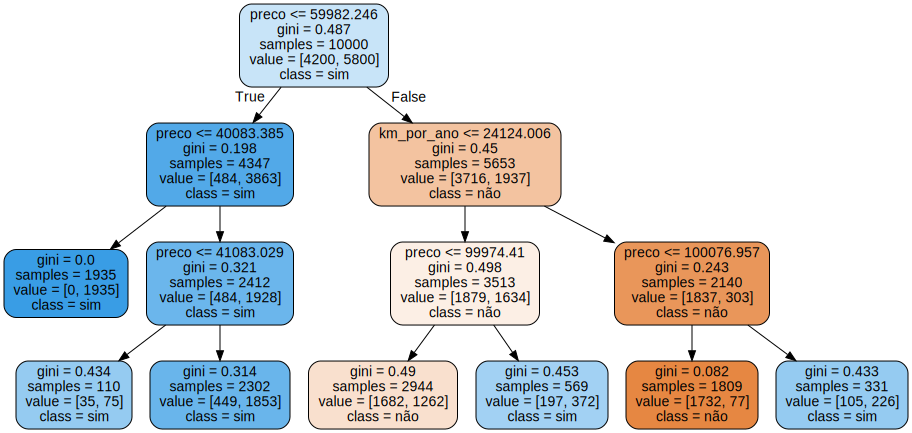

In [43]:
from sklearn.tree import export_graphviz
import graphviz

features = x_azar.columns
dot_data = export_graphviz(melhor, out_file=None, filled=True, rounded=True, class_names=["não", "sim"], feature_names=features)
graph = graphviz.Source(dot_data)
graph